In [ ]:
import math
import torch


# for every pose cell, calculate the velocity shift
def inject_activity(P, v, theta, omega, k_x=1, k_y=1, k_theta=1):
    updated_P = torch.clone(P)
    v_x = v * math.cos(theta) * k_x
    v_y = v * math.sin(theta) * k_y
    v_theta = k_theta * omega
    print(f"v_x: {v_x}, v_y: {v_y}, v_theta: {v_theta}")
    delta_x = math.floor(v_x)
    delta_f_x = v_x - delta_x
    delta_y = math.floor(v_y)
    delta_f_y = v_y - delta_y
    delta_theta = math.floor(v_theta)
    delta_f_theta = v_theta - delta_theta
    print(
        f"delta_f_x: {delta_f_x}, delta_x: {delta_x}, delta_f_y: {delta_f_y}, delta_y: {delta_y}, delta_f_theta: {delta_f_theta}, delta_theta: {delta_theta}"
    )
    kD, kH, kW = min(2, P.shape[0]), min(2, P.shape[1]), min(2, P.shape[2])

    alpha = calculate_alpha(
        delta_f_x,
        delta_f_y,
        delta_f_theta,
        shape=(kD, kH, kW),
    )

    shifted = torch.roll(P, shifts=(delta_theta, delta_x, delta_y), dims=(0, 1, 2))
    print("shifted", shifted)
    padded = torch.nn.functional.pad(
        shifted.unsqueeze(0).unsqueeze(0),
        (kW // 2, 0, kH // 2, 0, kD // 2, 0),
        mode="circular",
    )  # pad with circular padding
    # apply the convulution in the flipped directions
    print("padded", padded)
    flipped = torch.flip(padded, dims=(0, 1, 2, 3, 4))
    print("flipped", flipped)
    updated_P = (
        torch.nn.functional.conv3d(
            flipped,
            alpha.unsqueeze(0).unsqueeze(0),
            stride=1,
            padding=0,
        )
        .squeeze(0)
        .squeeze(0)
    )
    print("updated_P", updated_P)
    return updated_P.flip(0, 1, 2)  # flip back to original orientation


def calculate_velocity_shift(P, l, m, n, delta_x, delta_y, delta_theta, alpha):
    change = 0
    # print(alpha.shape)
    for t in range(delta_theta, delta_theta + len(alpha)):
        for x in range(delta_x, delta_x + len(alpha[0])):
            for y in range(delta_y, delta_y + len(alpha[0][0])):
                change += (
                    alpha[t - delta_theta][x - delta_x][
                        y - delta_y
                    ]  # paper does x y theta (but there alpha indices are weird)
                    * P[(n + t) % len(P)][(l + x) % len(P[0])][(m + y) % len(P[0][0])]
                )

    print("change", change)
    return change


def calculate_alpha(
    delta_f_x, delta_f_y, delta_f_theta, shape=(2, 2, 2)
):  # delta_x, delta_y, delta_theta
    alpha = torch.zeros(shape)
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            for k in range(0, shape[2]):
                alpha[i][j][k] = g(delta_f_theta, i) * g(delta_f_x, j) * g(delta_f_y, k)
    print("alpha", alpha)
    return alpha


# this seemingly has some errors in the paper as b can be values other than 0 or 1, but we can have any (integer) value for b (maybe we need to tune k? or is it mod?)
def g(a, b):
    if b == 0:
        return 1 - a
    else:
        return a

In [72]:
# MIGHT BE DOUBLE COUNTING P[i][j][k], since i do the += and do a copy (not fresh)
import torch
import math


def generate_epsilon(N_x, N_y, sigma):
    """
    Generate a 2D Gaussian kernel (epsilon) for the given dimensions and standard deviation.
    """
    kernel = torch.zeros((N_x, N_y))
    for i in range(N_x):
        for j in range(N_y):
            x = i - N_x // 2
            y = j - N_y // 2
            kernel[i, j] = math.exp(-(x**2 + y**2) / (2 * sigma**2))
    return kernel


def update_internal_P_jk(P, epsilon):
    assert len(P.shape) == 3, "P should be a 3D matrix. (x, y, theta)"
    updated_P = torch.clone(P)
    # for every layer
    p_x = (
        ((len(P[0])) // 2, (len(P[0]) - 1) // 2)
        if len(P[0]) % 2 == 0
        else ((len(P[0])) // 2, (len(P[0]) // 2))
    )
    p_y = (
        ((len(P[0][0])) // 2, (len(P[0][0]) - 1) // 2)
        if len(P[0][0]) % 2 == 0
        else ((len(P[0][0])) // 2, (len(P[0][0]) // 2))
    )
    padded = torch.nn.functional.pad(
        P,
        p_x + p_y,
        # mode="circular",
        mode="constant",
        value=0,
    )  # pad the tensor with zeros
    # print(padded)
    print(f"padded shape: {padded.shape}")
    updated_P = torch.nn.functional.conv2d(
        padded.unsqueeze(1),
        epsilon.unsqueeze(0).unsqueeze(0),
        padding="valid",
        stride=1,
    )
    print(f"updated shape: {updated_P.shape}")
    updated_P = updated_P.reshape(P.shape)

    return P + updated_P


def generate_delta(N_theta, sigma, gamma=2):
    delta = torch.zeros(N_theta)
    for i in range(N_theta):
        x = i - N_theta // 2
        delta[i] = math.exp(-(x**2) / (2 * sigma**2))

    return delta[
        (N_theta // 2) - gamma : (N_theta // 2) + gamma + 1
    ]  # cut off the first and last gamma values


def update_inter_layer_P_ijk(P, delta):
    assert len(P.shape) == 3, f"P should be a 3D matrix. (x, y, theta), got {P.shape}"
    updated_P = torch.clone(P)
    print(f"P shape: {P.unsqueeze(0).shape}")
    # pad theta layers circularly
    padded = torch.nn.functional.pad(
        P.permute(1, 2, 0).unsqueeze(0),
        (len(delta) // 2, len(delta) // 2) + (0, 0) + (0, 0),
        mode="circular",
    )
    print(f"padded shape: {padded.shape}")
    padded = padded.reshape(P.shape[0] * P.shape[1], 1, -1)
    # print(padded[0])
    updated_P = torch.nn.functional.conv1d(
        padded,
        delta.unsqueeze(0).unsqueeze(0),
        padding="valid",
        stride=1,
    )
    print(f"updated shape: {updated_P.shape}")
    updated_P = updated_P.permute(2, 0, 1).reshape(P.shape)
    return P + updated_P


def global_inhibition(P, inhibition_constant=0.004):
    assert len(P.shape) == 3, "P should be a 3D matrix. (x, y, theta)"
    updated_P = torch.clip(
        P + inhibition_constant * (P - torch.max(P)), min=0
    )  # clip to avoid negative values
    return updated_P


def normalize(P):
    return P / torch.sum(P)  # normalize the probabilities

In [86]:
updated_P = torch.tensor(
    [
        [
            [1.0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
    ]
)

# updated_P = torch.zeros((5, 5, 5))
# updated_P[0, 0, 0] = 0.15
# updated_P[0, 0, 1] = 0.1
# updated_P[0, 0, 2] = 0.1

# updated_P[0, 1, 0] = 0.1
# updated_P[0, 1, 1] = 0.1

# updated_P[3, 3, 2] = 0.1
# updated_P[3, 4, 4] = 0.1
# updated_P[4, 4, 0] = 0.1
# updated_P[4, 4, 1] = 0.1
# updated_P[4, 4, 2] = 0.05
print("updated_P", updated_P)

updated_P tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])


In [88]:
updated_P = inject_activity(
    updated_P,
    v=0.3,
    theta=math.pi / 2,
    omega=0,
    k_x=1,
    k_y=1,
    k_theta=1,
)

print(updated_P)

epsilon = generate_epsilon(3, 3, 0.4)
print("epsilon", epsilon)
delta = generate_delta(3, 0.4, gamma=1)
print("delta", delta)

updated_P = update_internal_P_jk(updated_P, epsilon)
updated_P = update_inter_layer_P_ijk(updated_P, delta)
updated_P = global_inhibition(updated_P, 0.1)
updated_P = normalize(updated_P)
print("updated_P", updated_P)

0.3 0.0
0.7
v_x: 4.286263797015736e-17, v_y: 0.7, v_theta: 0
delta_f_x: 4.286263797015736e-17, delta_x: 0, delta_f_y: 0.7, delta_y: 0, delta_f_theta: 0.0, delta_theta: 0
alpha tensor([[[3.0000e-01, 7.0000e-01],
         [1.2859e-17, 3.0004e-17]],

        [[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]]])
shifted tensor([[[0.0000, 0.7189, 0.2811],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]]])
padded tensor([[[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.2811, 0.0000, 0.7189, 0.2811],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000,

In [7]:
from matplotlib.pyplot import disconnect


N_theta = 50
N_x = 50
N_y = 50

# P = torch.tensor(
#     [
#         [
#             [0.2, 0.1, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.2, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0.1, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.1, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0.05, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.05, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0.1, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.1, 0],
#             [0, 0, 0, 0, 0],
#         ],
#     ]
# )

P = torch.rand(N_theta, N_x, N_y)
P[0][0][0] += N_theta * N_x * N_y
P[-5][-5][-5] += N_theta * N_x * N_y
P = P / torch.sum(P)  # normalize the probabilities

epsilon = generate_epsilon(N_x, N_y, 0.3)
print("Original P:")
print(P)
print("Exciting nearby with internal xy connections")
print("Epsilon:")
print(epsilon)
updated_P = update_internal_P_jk(P, epsilon)
print("Updated P:")
print(updated_P)

delta = generate_delta(N_theta, 0.3)
print("Delta:")
print(delta)
print("Exciting nearby with intra layer")
updated_P = update_inter_layer_P_ijk(P, delta)
print("Updated P:")
print(updated_P)


# print("Only checks 2 layers away")
# disconnect_P = torch.tensor(
#     [
#         [
#             [0.2, 0.1, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.2, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0.2, 0.1, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0.2, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#         ],
#         [
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#             [0, 0, 0, 0, 0],
#         ],
#     ]
# )
# updated_P = update_inter_layer_P_ijk(disconnect_P, delta)
# print("Updated P:")
# print(updated_P)

print("all together: ")
updated_P = update_internal_P_jk(P, epsilon)
print("Updated P:")
print(updated_P)
updated_P = update_inter_layer_P_ijk(updated_P, delta)
print("Updated P:")
print(updated_P)
print("Global inhibition")
updated_P = global_inhibition(updated_P)
print("Updated P:")
print(updated_P)
updated_P = normalize(updated_P)
print("Updated P:")
print(updated_P)

print("Will reach one fixed point")
updated_P = P
for i in range(50):
    print("Iteration", i)
    updated_P = update_internal_P_jk(updated_P, epsilon)
    updated_P = update_inter_layer_P_ijk(updated_P, delta)
    updated_P = global_inhibition(updated_P)
    updated_P = normalize(updated_P)
    print(updated_P.max())

print("Updated P:")
print(updated_P)
print(len(updated_P[updated_P > 0]))

Original P:
tensor([[[4.0012e-01, 1.6125e-06, 2.1707e-06,  ..., 9.2588e-07,
          3.8106e-08, 2.7526e-06],
         [2.6876e-06, 6.8536e-07, 2.6829e-06,  ..., 1.1175e-06,
          2.0893e-07, 2.9792e-07],
         [2.1624e-06, 1.1046e-06, 1.6119e-06,  ..., 2.6417e-06,
          6.4222e-08, 2.6045e-06],
         ...,
         [9.5335e-07, 2.7144e-06, 5.6532e-07,  ..., 2.0815e-06,
          7.1701e-07, 7.5563e-07],
         [1.0865e-06, 1.1099e-06, 1.4740e-06,  ..., 1.9053e-06,
          1.1530e-06, 1.0322e-06],
         [5.1168e-07, 2.0152e-06, 2.2646e-06,  ..., 1.6458e-06,
          2.3190e-06, 1.8872e-06]],

        [[7.5764e-07, 7.7257e-07, 1.3300e-06,  ..., 1.8107e-06,
          1.2330e-06, 2.7504e-06],
         [1.4092e-06, 2.4761e-06, 2.8555e-06,  ..., 6.0024e-07,
          1.3609e-06, 2.9958e-06],
         [2.8478e-06, 2.4829e-06, 1.3777e-06,  ..., 5.2458e-07,
          1.3236e-06, 2.1938e-07],
         ...,
         [1.4168e-06, 1.5051e-06, 1.2433e-06,  ..., 1.6733e-06,
   

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def make_video(imgs, filename="video.mp4"):
    # print(imgs.shape)
    fig, ax = plt.subplots(
        nrows=1, ncols=imgs[0].shape[0], figsize=(10 * imgs[0].shape[0], 10)
    )
    ims = []

    artists = [
        ax[j].imshow(
            imgs[0][j],
            # animated=True,
            cmap="hot",
            vmin=0,
            vmax=1,
        )
        for j in range(imgs[0].shape[0])
    ]

    def plot_func(i):
        for j in range(imgs[0].shape[0]):
            artists[j].set_array(imgs[i][j])
        return artists

    # ims = [ax.imshow(imgs[i], animated=True, cmap="hot", vmin=0, vmax=1) for i in range(len(imgs))]
    # ims = [ax.imshow(imgs[i], animated=True, cmap="hot", vmin=0, vmax=1) for i in range(len(imgs))]

    ani = FuncAnimation(
        fig,
        plot_func,
        frames=len(imgs) - 1,
        interval=100,
        blit=True,
    )

    ani.save(filename, writer="ffmpeg", fps=10)
    plt.close(fig)  # Close the figure to avoid displaying it
    return ani

In [46]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from graph_utils import plot_probability_distribution_on_ax


def make_video_2(
    imgs,
    filename="video.mp4",
):
    fig = plt.figure(layout="constrained", figsize=(6, 3), dpi=100)
    gs = GridSpec(6, 6, figure=fig)

    text_artist = fig.suptitle("t=0")

    x_dist_ax = fig.add_subplot(gs[0, 0:6])
    y_dist_ax = fig.add_subplot(gs[1, 0:6])
    theta_dist_ax = fig.add_subplot(gs[2, 0:6])
    x_dist_ax.set_title("x dist")
    y_dist_ax.set_title("y dist")
    theta_dist_ax.set_title("θ dist")

    x_distributions = [torch.sum(img, dim=(0, 2)) for img in imgs]
    y_distributions = [torch.sum(img, dim=(0, 1)) for img in imgs]
    theta_distributions = [torch.sum(img, dim=(1, 2)) for img in imgs]

    x_dist_ax.set_xlim(0, len(x_distributions[0]))
    y_dist_ax.set_xlim(0, len(y_distributions[0]))
    theta_dist_ax.set_xlim(0, len(theta_distributions[0]))

    x_dist_artist = plot_probability_distribution_on_ax(x_distributions[0], x_dist_ax)
    y_dist_artist = plot_probability_distribution_on_ax(y_distributions[0], y_dist_ax)
    theta_dist_artist = plot_probability_distribution_on_ax(
        theta_distributions[0], theta_dist_ax
    )

    def plot_func(frame):
        x_dist_artist.set_data(values=x_distributions[frame], edges=None)
        y_dist_artist.set_data(values=y_distributions[frame], edges=None)
        theta_dist_artist.set_data(values=theta_distributions[frame], edges=None)

        text_artist.set_text(f"t={frame}")
        return (
            x_dist_artist,
            y_dist_artist,
            theta_dist_artist,
            text_artist,
        )

    ani = FuncAnimation(fig, plot_func, len(imgs) - 1, blit=False)
    ani.save(filename, writer="ffmpeg", fps=10)

In [58]:
# Generate a random 5x5x5 tensor
N_theta = 5
N_x = 5
N_y = 5
P = torch.rand(N_theta, N_x, N_y)
# packet 1
P[0][0][0] += N_theta
P[0][0][1] += N_theta
P[4][4][4] += N_theta
# packet 2
P[2][2][2] += N_theta
P[2][2][2] += N_theta
# Normalize the tensor
P = P / torch.sum(P)

# Print the normalized tensor
print("Normalized P:")
print(P)


# make a video of the
def test_inhibition(P, inhibition_constant, sigma, velocity=0, theta=0, omega=0):
    updated_P = P.clone()
    epsilon = generate_epsilon(N_x, N_y, sigma)
    delta = generate_delta(N_theta, sigma)
    imgs = []
    for i in range(50):
        print("Iteration", i)
        updated_P = inject_activity(
            updated_P,
            v=velocity,
            theta=theta,
            omega=omega,
            k_x=1,
            k_y=1,
            k_theta=1,
        )
        updated_P = update_internal_P_jk(updated_P, epsilon)
        updated_P = update_inter_layer_P_ijk(updated_P, delta)
        updated_P = global_inhibition(updated_P, inhibition_constant)
        updated_P = normalize(updated_P)
        print(updated_P.max())
        imgs.append(updated_P.clone().detach())
    # make_video(
    #     imgs,
    #     filename=f"video_{inhibition_constant}_{sigma}.mp4",
    # )
    return imgs

Normalized P:
tensor([[[0.0597, 0.0622, 0.0112, 0.0058, 0.0103],
         [0.0032, 0.0010, 0.0090, 0.0081, 0.0007],
         [0.0037, 0.0090, 0.0047, 0.0077, 0.0035],
         [0.0071, 0.0110, 0.0064, 0.0037, 0.0087],
         [0.0098, 0.0073, 0.0023, 0.0042, 0.0089]],

        [[0.0099, 0.0083, 0.0003, 0.0027, 0.0011],
         [0.0105, 0.0040, 0.0069, 0.0008, 0.0045],
         [0.0080, 0.0110, 0.0101, 0.0044, 0.0059],
         [0.0064, 0.0017, 0.0084, 0.0097, 0.0034],
         [0.0049, 0.0093, 0.0111, 0.0052, 0.0076]],

        [[0.0016, 0.0078, 0.0065, 0.0022, 0.0033],
         [0.0082, 0.0102, 0.0099, 0.0111, 0.0059],
         [0.0013, 0.0033, 0.1143, 0.0075, 0.0058],
         [0.0033, 0.0041, 0.0111, 0.0072, 0.0032],
         [0.0062, 0.0036, 0.0040, 0.0014, 0.0020]],

        [[0.0056, 0.0040, 0.0003, 0.0092, 0.0025],
         [0.0064, 0.0005, 0.0051, 0.0042, 0.0041],
         [0.0057, 0.0051, 0.0091, 0.0053, 0.0002],
         [0.0080, 0.0057, 0.0097, 0.0030, 0.0106],
         [0

Testing inhibition constant 0.004 and sigma 0.1
Iteration 0
v_x: 0.0, v_y: 0.0, v_theta: 0
delta_f_x: 0.0, delta_x: 0, delta_f_y: 0.0, delta_y: 0, delta_f_theta: 0.0, delta_theta: 0
alpha tensor([[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
padded shape: torch.Size([5, 9, 9])
updated shape: torch.Size([5, 1, 5, 5])
P shape: torch.Size([1, 5, 5, 5])
padded shape: torch.Size([1, 5, 5, 9])
updated shape: torch.Size([25, 1, 5])
tensor(0.1206)
Iteration 1
v_x: 0.0, v_y: 0.0, v_theta: 0
delta_f_x: 0.0, delta_x: 0, delta_f_y: 0.0, delta_y: 0, delta_f_theta: 0.0, delta_theta: 0
alpha tensor([[[1., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
padded shape: torch.Size([5, 9, 9])
updated shape: torch.Size([5, 1, 5, 5])
P shape: torch.Size([1, 5, 5, 5])
padded shape: torch.Size([1, 5, 5, 9])
updated shape: torch.Size([25, 1, 5])
tensor(0.1274)
Iteration 2
v_x: 0.0, v_y: 0.0, v_theta: 0
delta_f_x: 0.0, delta_x: 0, delta_f_y: 0.0, delta_y: 0, delta_f_t

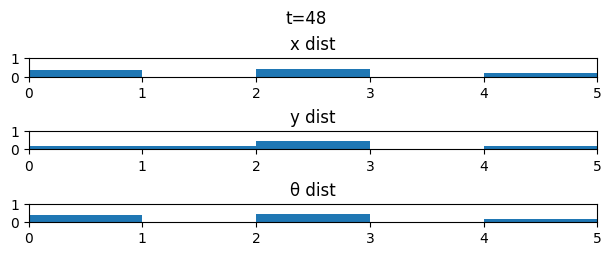

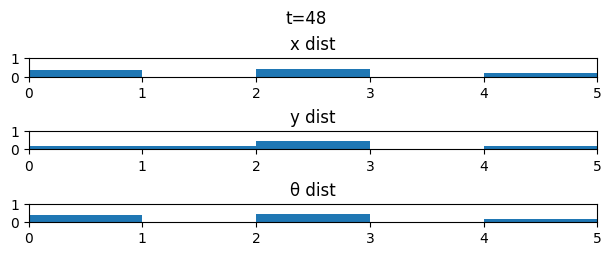

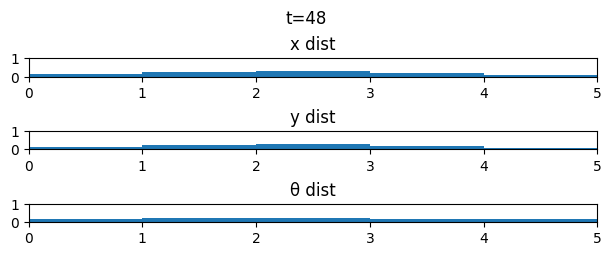

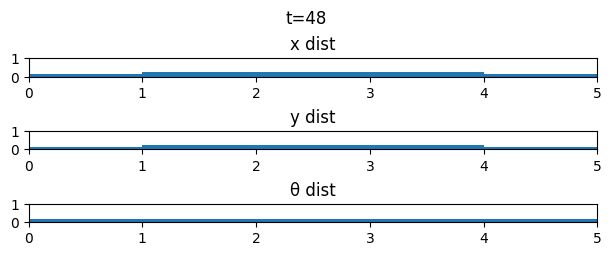

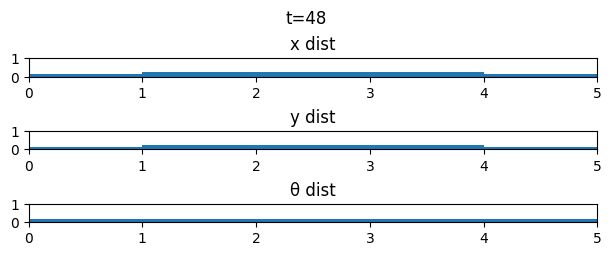

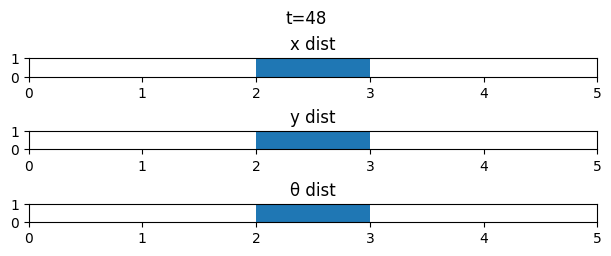

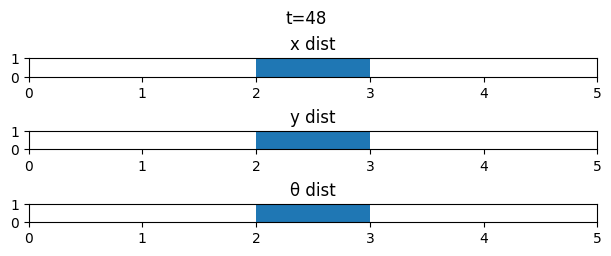

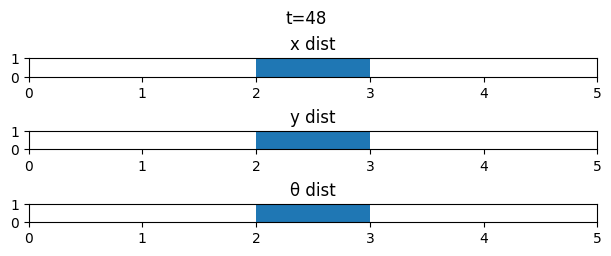

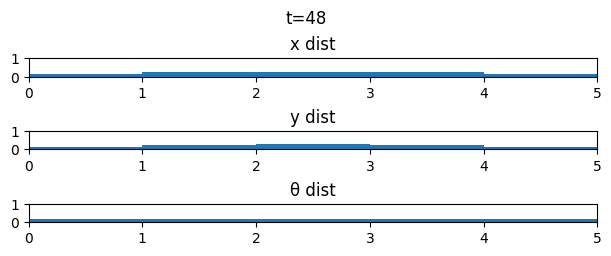

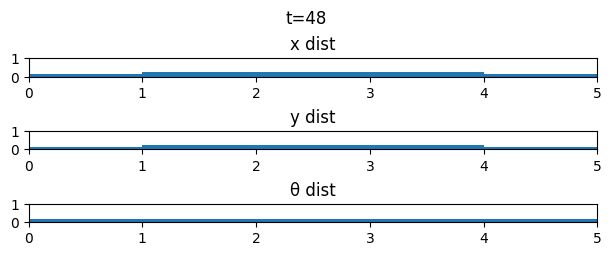

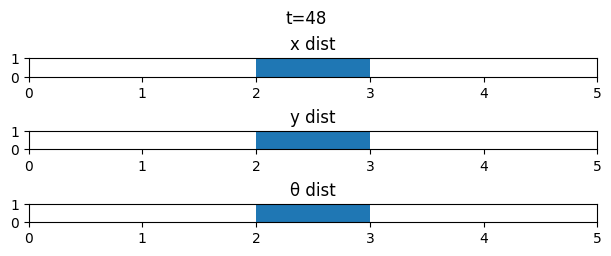

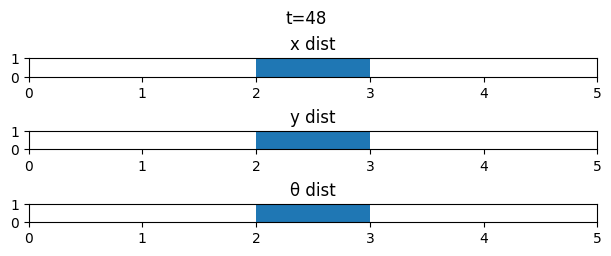

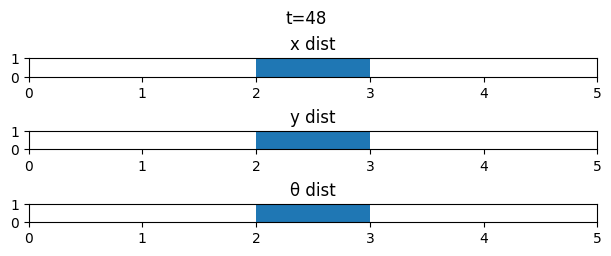

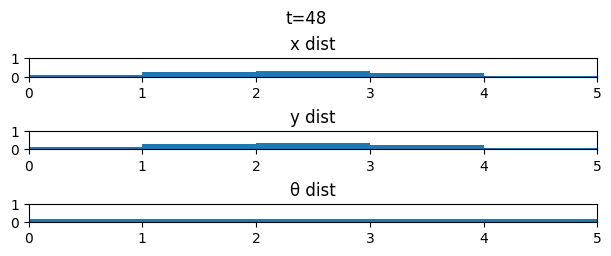

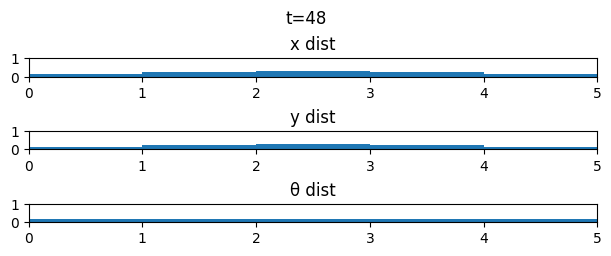

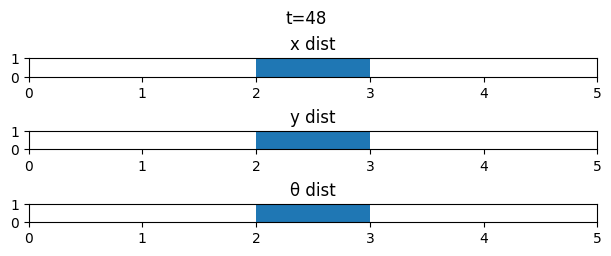

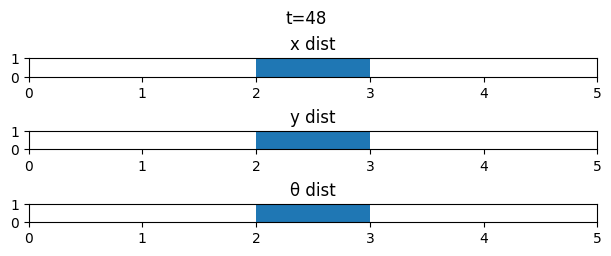

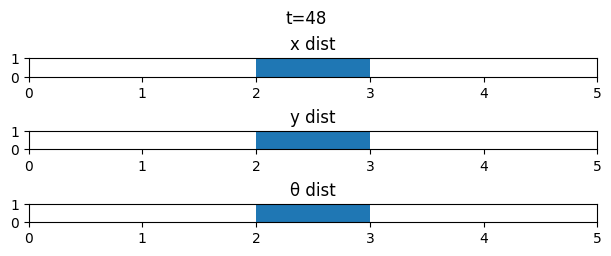

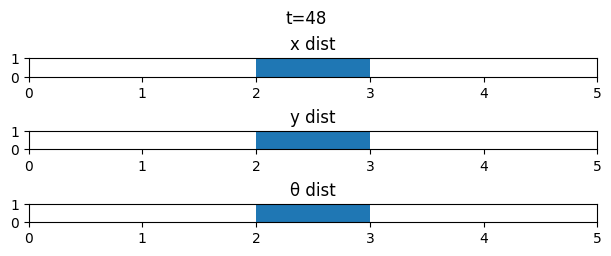

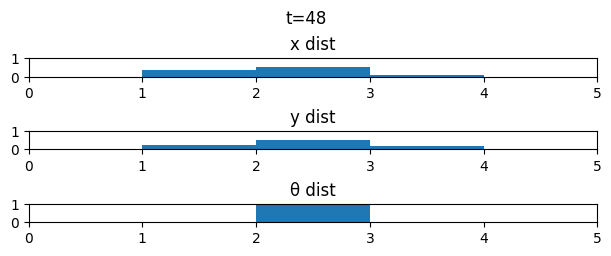

In [59]:
inhibhition_constants = [0.004, 0.04, 0.1, 0.4]
sigmas = [0.1, 0.2, 0.4, 0.8, 1.0]

for inhibition_constant in inhibhition_constants:
    for sigma in sigmas:
        print(f"Testing inhibition constant {inhibition_constant} and sigma {sigma}")
        imgs = test_inhibition(
            P,
            inhibition_constant=inhibition_constant,
            sigma=sigma,
            velocity=0.0,
            theta=0,
            omega=0,
        )
        make_video_2(
            imgs,
            filename=f"video_{inhibition_constant}_{sigma}.mp4",
        )